make enrichment plots for snvs!

In [1]:
import change_path
import sequence
import train_TFmodel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ucscgenome
from tqdm import tqdm
import datagen

from keras.models import load_model
import pickle


#load in the DNA
genome19 = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
genome38 = ucscgenome.Genome('/home/kal/.ucscgenome/hg38.2bit')

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/.ipython']


Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


In [ ]:
# get some datasets!
ibd_c = pd.read_table('/home/kal/K27act_models/eqtl_data/IBD_credible_sets.csv')
print(ibd_c.keys())

ibd_c['near_gene'] = [d>0 for d in ibd_c['credible_nGene']]
ibd_c.head()

In [ ]:
# make label type enrichemnt plots
# replicate previous posterior prob plots from the promotor label
num_groups = 5
split_column='Prob.lead'
test_columns=['near_gene']
dataset = ibd_c
print(np.max(ibd_c[split_column]))
print(np.min(ibd_c[split_column]))
bins=[0, .05, .1, .25, .75, 1]
for test_column in test_columns:
    enrichment_data=list()
    names=list()
    for i in range(num_groups):
        names.append('{:.2f}-{:.2f}'.format(bins[i], bins[i+1]))
        subset = dataset[(dataset[split_column] >= bins[i]) & (dataset[split_column] < bins[i+1])]
        enrichment_data.append(len(subset[(subset[test_column])])/len(subset))

    plt.xticks(range(num_groups), names, rotation=45)
    plt.title('{} enrichment for {}'.format(split_column, test_column))
    plt.xlabel(test_column)
    plt.ylabel('Enrichment (num samples/total num)')
    plt.bar(range(num_groups), enrichment_data)
    plt.show()

In [ ]:
ibd_all = pd.read_table('/home/kal/K27act_models/eqtl_data/IBD_list_of_varients.csv')
print(ibd_all.keys())
ibd_all.head()

In [ ]:
# make label type enrichemnt plots
# replicate previous posterior prob plots from the promotor label
num_groups = 5
split_column='P_mean_95'
test_columns=['Coding', 'TFBS', 'epigenetic']
dataset = ibd_all
bins=[0, .01, .05, .25, .75, 1]
for test_column in test_columns:
    enrichment_data=list()
    names=list()
    for i in range(num_groups):
        names.append('{:.2f}-{:.2f}'.format(bins[i], bins[i+1]))
        subset = dataset[(dataset[split_column] >= bins[i]) & (dataset[split_column] < bins[i+1])]
        enrichment_data.append(len(subset[(subset[test_column] != 'False')])/len(subset))

    plt.xticks(range(num_groups), names, rotation=45)
    plt.title('{} enrichment for {}'.format(split_column, test_column))
    plt.xlabel('Bins for {}'.format(split_column))
    plt.ylabel('Enrichment (num samples/total num)')
    plt.bar(range(num_groups), enrichment_data)
    plt.show()

In [2]:
# load in eqtl data

# posterior prob bins (from joe)
pp_bins = [0, .01, .05, .25, .75, 1]

eqtl = pd.read_table('/home/kal/K27act_models/eqtl_data/Cells_EBV-transformed_lymphocytes.hg19.csv')
print(eqtl.keys())
eqtl['100_tss'] = [abs(d) <= 100 for d in eqtl['tss_distance']]
print(len(eqtl))
print(len(eqtl[eqtl['missingness'] < .02]))
print(sum(eqtl['100_tss']))
eqtl.head()

Index(['chr', 'position', 'variant_id', 'refAllele', 'altAllele', 'gene_id',
       'variant', 'prob.in.set', 'PosteriorProb', 'gene_name',
       'CredibleSetSize', 'CredibleSet', 'CredibleSetName',
       'median.expression', 'missingness', 'mappability.k50', 'tss_distance',
       'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se',
       'eqtl_name'],
      dtype='object')
235686
218779
875


,chr,position,variant_id,refAllele,altAllele,gene_id,variant,prob.in.set,PosteriorProb,gene_name,...,mappability.k50,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,eqtl_name,100_tss
0,chr10,102087037,chr10_100327281_T_C_b38,T,C,ENSG00000224934.2,102087038,0.019453,0.023665,RP11-441O15.3,...,1.0,896090,33,36,0.122449,0.000652,0.375461,0.107300,chr10:102087038:RP11-441O15.3,False
1,chr10,102087112,chr10_100327356_G_T_b38,G,T,ENSG00000224934.2,102087113,0.005739,0.006981,RP11-441O15.3,...,1.0,896165,52,58,0.197279,0.001981,-0.268628,0.084970,chr10:102087113:RP11-441O15.3,False
2,chr10,102103036,chr10_100343280_C_T_b38,C,T,ENSG00000119929.12,102103037,0.051836,0.047800,CUTC,...,1.0,620362,33,33,0.112245,0.000046,0.452428,0.107065,chr10:102103037:CUTC,False
3,chr10,102105629,chr10_100345873_T_C_b38,T,C,ENSG00000119929.12,102105630,0.441053,0.406717,CUTC,...,1.0,622955,32,32,0.108844,0.000003,0.502150,0.102816,chr10:102105630:CUTC,False
4,chr10,102127491,chr10_100367735_A_G_b38,A,G,ENSG00000119929.12,102127492,0.043166,0.039806,CUTC,...,1.0,644817,38,40,0.136054,0.000060,-0.380238,0.091461,chr10:102127492:CUTC,False


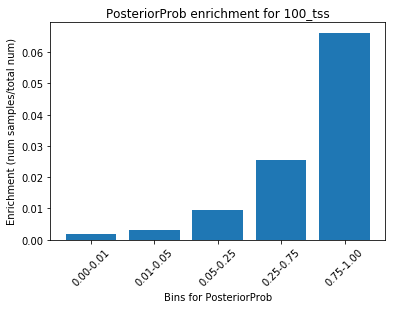

In [3]:
# make label type enrichemnt plots

# replicate previous posterior prob plots
num_groups = 5
split_column='PosteriorProb'
dataset = eqtl
bins=pp_bins
    
test_columns=['100_tss']
for test_column in test_columns:
    enrichment_data=list()
    names=list()
    for i in range(num_groups):
        names.append('{:.2f}-{:.2f}'.format(bins[i], bins[i+1]))
        subset = dataset[(dataset[split_column] >= bins[i]) & (dataset[split_column] < bins[i+1])]
        enrichment_data.append(len(subset[(subset[test_column])])/len(subset))

    plt.xticks(range(num_groups), names, rotation=45)
    plt.title('{} enrichment for {}'.format(split_column, test_column))
    plt.xlabel('Bins for {}'.format(split_column))
    plt.ylabel('Enrichment (num samples/total num)')
    plt.bar(range(num_groups), enrichment_data)
    plt.show()

In [4]:
# get some models! 
ml_models = {'sum_pwm':load_model('/home/kal/K27act_models/convolution_model/20180711_144600_counts_pwm_sum/final_model.h5')}

In [5]:
def snv_gen(peaks, genome, alt=False, seq_length=1024):
    """Generate sequnces from snv data.
    
    Arguments:
        peaks -- from a bed file.
        genome -- to pull bed from.
    Keywords:
        alt -- give alternate allele version.
    Returns:
        seq -- sequence with the alternate or refernce allele, centered around the position. """
    for index, row in peaks.iterrows():
        try:
            seq = datagen.get_sample(row, genome=genome)[0]
            if alt:
                new_seq = np.insert(sequence.encode_to_onehot(row.altAllele.lower()), 0, seq[seq_length//2:seq_length//2+len(row.altAllele)][:,0], axis=1)
                part_seq = np.append(seq[:seq_length//2], new_seq, axis=0)
                seq = np.append(part_seq, seq[seq_length//2+len(row.refAllele):], axis=0) 
            else:
                new_seq = np.insert(sequence.encode_to_onehot(row.refAllele.lower()), 0, seq[seq_length//2:seq_length//2+len(row.refAllele)][:,0], axis=1)
                part_seq = np.append(seq[:seq_length//2], new_seq, axis=0)
                seq = np.append(part_seq, seq[seq_length//2+len(row.refAllele):], axis=0)
            if (row.refAllele).lower()[0] != (genome[row.chr][row.position]).lower():
                print('Should be {}'.format(genome[row.chr][row.position].lower()))
                print('Actually is {}'.format(row.refAllele.lower()))
                print('Alternate is {}'.format(row.altAllele.lower()))
                raise IndexError('Reference allele does not match reference genome')
            yield seq
        except IndentationError as e:
            print(e)
            print(row)
        

In [18]:
def predict_snv(model, peaks, genome=None, act=False, seq_length=1024):
    """Predict from a bed file with chr, position, refAllele, altAllele.
 
    Arguments:
        peaks -- the bed file in pd table form.
    Keywords:
        genome -- default is hg19.
    Outputs:
        refpreds -- predictions for each row with reference allele. 
        altpreds -- predictions for each row with alternate allele. 
    """
     # get the genome and bed file regions
    if genome == None:
        genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
    # predict over the rows
    refpreds = []
    peaks['end'] = peaks['refend']
    batchgen = train_TFmodel.filled_batch(snv_gen(peaks, genome, alt=False, seq_length=seq_length), fillvalue=np.zeros((seq_length, 5)))
    for batch in batchgen:
        if batch.shape == (32, seq_length, 5):
            refpreds.append(model.predict_on_batch(batch))
    refpreds = np.asarray(refpreds).flatten()[:len(peaks)]

    altpreds = []
    peaks['end'] = peaks['altend']
    batchgen = train_TFmodel.filled_batch(snv_gen(peaks, genome, alt=True, seq_length=seq_length), fillvalue=np.zeros((seq_length, 5)))
    for batch in batchgen:
        if batch.shape == (32, seq_length, 5):
            altpreds.append(model.predict_on_batch(batch))
    altpreds = np.asarray(altpreds).flatten()[:len(peaks)]
    return refpreds, altpreds


In [14]:
# predictions at p values
key='sum_pwm'
model=ml_models[key]
seq_length=1024
dataset = eqtl.sample(1000)
dividing_key='PosteriorProb'
genome=genome19
dataset.keys()

Index(['chr', 'position', 'variant_id', 'refAllele', 'altAllele', 'gene_id',
       'variant', 'prob.in.set', 'PosteriorProb', 'gene_name',
       'CredibleSetSize', 'CredibleSet', 'CredibleSetName',
       'median.expression', 'missingness', 'mappability.k50', 'tss_distance',
       'ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se',
       'eqtl_name', '100_tss', 'altend', 'start', 'refend', 'score'],
      dtype='object')

In [15]:
# prepare for testing
altend=list()
for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
    if len(row.refAllele) == len(row.altAllele):
        altend.append(row.position+seq_length//2)
    else:
        altend.append(row.position+seq_length//2 + len(row.refAllele) - len(row.altAllele))
dataset['altend'] = altend
dataset['start'] = dataset.position-seq_length//2
dataset['refend'] = dataset.position+seq_length//2
dataset['score'] = np.nan
dataset['altend'] = dataset['altend'].astype(int)

dataset = dataset[(dataset['refAllele'] !='D') & (dataset['refAllele'] !='I')]# I can't deal with deletions or insertions

100%|██████████| 1000/1000 [00:00<00:00, 11228.38it/s]


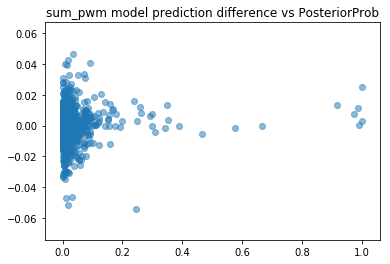

In [30]:
# hexbin correlations
r, a = predict_snv(model, dataset, genome)
diff = r-a

plt.scatter(dataset[dividing_key], diff, alpha=0.5)
plt.title('{} model prediction difference vs {}'.format(key, dividing_key))
plt.show()

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.00-0.01: 477 total, 264 with difference
0.01-0.05: 392 total, 217 with difference
0.05-0.25: 112 total, 65 with difference
0.25-0.75: 13 total, 7 with difference
0.75-1.00: 5 total, 3 with difference


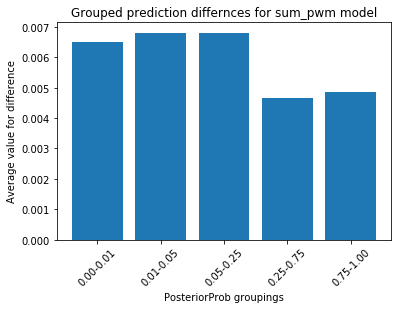

In [26]:
# make the chart
num_groups = 5
enrichment=[0]*num_groups
name=list()
bins=pp_bins
min_diff = 0.005
for i in range(num_groups):
    subset = dataset[(dataset[dividing_key] >= bins[i]) & (dataset[dividing_key] < bins[i+1])]
    r, a = predict_snv(model, subset, genome)
    diff = r-a
    enrichment[i] = sum([abs(d) for d in diff if abs(d) > min_diff])/len(diff)
    name.append('{:.2f}-{:.2f}'.format(bins[i], bins[i+1]))
    print('{}: {} total, {} with difference'.format(name[i], len(subset), len([d for d in diff if abs(d) > min_diff])))

plt.title('Grouped prediction differnces for {} model'.format(key))
plt.bar(range(num_groups), enrichment)
plt.xticks(range(num_groups), name, rotation=45)
plt.xlabel('{} groupings'.format(dividing_key))
plt.ylabel('Average value for difference')
plt.show()

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.00-0.01: 477 total, 264 with difference
0.01-0.05: 392 total, 217 with difference
0.05-0.25: 112 total, 65 with difference
0.25-0.75: 13 total, 7 with difference
0.75-1.00: 5 total, 3 with difference


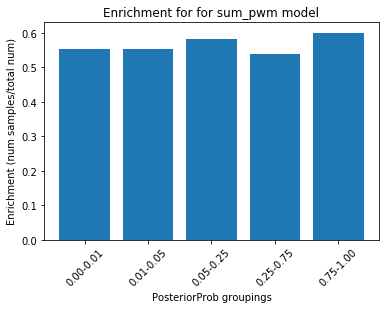

In [27]:
# make the chart
num_groups = 5
enrichment=[0]*num_groups
name=list()
bins=pp_bins
for i in range(num_groups):
    subset = dataset[(dataset[dividing_key] >= bins[i]) & (dataset[dividing_key] < bins[i+1])]
    r, a = predict_snv(model, subset, genome)
    diff = r-a
    enrichment[i] = len([d for d in diff if abs(d) > min_diff])/len(diff)
    name.append('{:.2f}-{:.2f}'.format(bins[i], bins[i+1]))
    print('{}: {} total, {} with difference'.format(name[i], len(subset), len([d for d in diff if abs(d) > min_diff])))

plt.title('Enrichment for for {} model'.format(key))
plt.bar(range(num_groups), enrichment)
plt.xticks(range(num_groups), name, rotation=45)
plt.xlabel('{} groupings'.format(dividing_key))
plt.ylabel('Enrichment (num samples/total num)')
plt.show()

In [ ]:
import imp
datagen = imp.reload(datagen)